In [1]:
from __future__ import print_function,division
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from utils.helpers import *
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import adjusted_rand_score,silhouette_score
from sklearn.cluster import KMeans,AgglomerativeClustering
from  collections import Counter as counter
%matplotlib inline

stopword_list = set()
stopword_list.update(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jojo89/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# load the data
data_pack = pd.read_json('clusters.json')
data_pack.head(5)

,id,text,title,lang,date,cluster,cluster_name
0,https://www.fondsk.ru/news/2020/03/24/litva-ne...,The coronavirus epidemic in Lithuania has clea...,"Lithuania: No Physicians, No Food Stock - Stra...",eng,2020-03-24 00:00:00,0,MS fails to respond
1,https://www.rubaltic.ru/article/politika-i-obs...,European experts say that the countries of Eas...,Coronavirus caused a catastrophe in the Baltic,eng,2020-03-19 08:50:37,0,MS fails to respond
2,http://pandemya.ru/shveciya-otkazalas-ot-borby...,Sweden refused to fight against coronavirus: “...,Sweden abandoned the fight against coronavirus...,eng,None,0,MS fails to respond
3,https://southfront.org/coronavirus-hysteria-hi...,"Donate\nDuring the past week, the center of th...",Coronavirus Hysteria Hits Russia As Europe Bec...,eng,2020-03-14 12:27:02,0,MS fails to respond
4,https://www.fondsk.ru/news/2020/03/24/shvedski...,The Swedish oligarchs in conjunction with the ...,Swedish capital slows down in an epidemic and ...,eng,2020-03-24 00:00:00,0,MS fails to respond


In [3]:
# Just shuffling the data_pack
from sklearn.utils import shuffle
data_pack=shuffle(data_pack)
data_pack.reset_index(drop=True,inplace=True)

In [4]:
# Number of entries with missing date
len(data_pack.date[data_pack.date=='None'])

66

In [5]:
#check the languages and clusters available
print(f'Language(s): {data_pack.lang.unique()}')
nb_clusters = len(data_pack.cluster_name.unique())
print(f' Total number of clusters: {nb_clusters} Clusters: {data_pack.cluster_name.unique()}')

Language(s): ['eng']
 Total number of clusters: 14 Clusters: ['USA created COVID-2019' 'Claims about China' 'Collapse'
 'Coronavirus is not serious' 'EU fails to respond' 'Miscellaneous'
 'Ukraine fails to respond' 'Origins' 'Secret plan of the global elite'
 'Properties' 'Cure' 'MS fails to respond' 'Anti-Russia' 'Was predicted']


In [6]:
data_pack.groupby(['cluster_name']).size()['Anti-Russia']

8

In [7]:
base_clusters = list(data_pack.groupby(['cluster_name']).size().index.values)

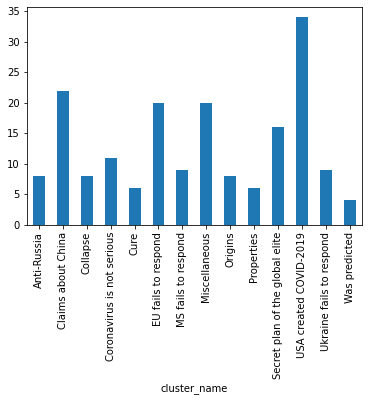

In [8]:
# Get the number of articles per cluster
data_pack.groupby(['cluster_name']).size().plot.bar()

In [9]:
# Combine the Title and Text to use in this work
data_pack['content'] = data_pack.title+' '+data_pack.text
#

In [10]:
data_pack.loc[data_pack['cluster_name']==base_clusters[1]].content

1      No Weapon Left Behind: America's Hybrid War on...
4      Phenomena Of Coronavirus Crisis Donate\nAs of ...
10     US tightens the noose on China as a result of ...
14     The coronavirus, a weapon that has fallen from...
15     This week the coronavirus was expelled and we ...
25     Pseudo-Apocalypse: Coronavirus Outbreak In Chi...
27     Coronavirus - a new US bio-weapon? The circums...
30     Corona and Huawei .. the new opium war Corona ...
48     Time will tell. 02/02/2020 Time will tell16 +\...
97     Zhirinovsky recommends: In an epidemic, no kis...
103    Issue 210: Dobrov On Air Issue 210\nOn air the...
108    Belyakov: coronavirus - a mutant mutation or a...
111    Khbarni: Corona imposes a new blockade on Iran...
120    Snarry Net - Russian politician: the United St...
124    Money and the world: Oscar, coronavirus and th...
126    How the situation with Koronaviru was reflecte...
133    A coronavirus to hack the world system The aca...
134    Issue 210: Dobrov On Air

In [11]:
# Generating finer grain clusters
# The data has already been partitioned into 14 different clusters
# Iteratively apply cluster to each cluster consisting of more than 1 document.
# Hierarchical cluster can be used but here we will apply kmeans to divide up the clusters

def ApplyCluster(data_frame,parent_cluster_col,parent_cluster_name,level=''):
  # Check the number of documents in the parent cluster before applying the algorithm
  # if it is 1 just return, else apply K-Mean to it.
  nb_elements = data_frame.groupby([parent_cluster_col]).size()[parent_cluster_name]
  # New Cluster splits will be assigned values in the column indicated by (new_column_name)
  new_column_name = 'cluster_L'+'/'+level
  #data_frame[new_column_name] = ''
  if nb_elements<2:
    print(f'No futher clusting is possible for the cluster at: {parent_cluster_name}')
    # Use the parent cluster name
    # Add a new column (new_column_name) with values equal to the content_label
    data_frame.loc[data_frame[parent_cluster_col]==parent_cluster_name,new_column_name]=parent_cluster_name+'/-'
    return data_frame,new_column_name
  else:
    # Get the text documents
    content = data_frame.loc[data_frame[parent_cluster_col]==parent_cluster_name].content
    tfidfVectorizer = TfidfVectorizer(max_features=20000,
                                      stop_words= stopword_list, 
                                      ngram_range=(1,3))
    prep_pipeline = Pipeline([('cleaner',BasicPreprocessor()),('vectorizer',tfidfVectorizer)])

    data_matrix = prep_pipeline.fit_transform(content)

    # Apply the KMean to the data Matrix
    try:
      # If we cant get 3 clusters use k=2
      km= KMeans(n_clusters=3,random_state=42,n_init=50,)
      km.fit(data_matrix)
    except:
      km= KMeans(n_clusters=2,random_state=42,n_init=50)
      km.fit(data_matrix)
      
    # Let see the articles per cluster returned
    content_label= [parent_cluster_name+'/'+str(l) for l in km.labels_.tolist()]
    #print('The new clusters are: ',content_label)

    
    # Add a new column (new_column_name) with values equal to the content_label
    data_frame.loc[data_frame[parent_cluster_col]==parent_cluster_name,new_column_name]=content_label

    return data_frame,new_column_name


import copy
def getFinerGrain(data_frame,base_column_name,base_clusters,levels=1,):
  # Iterate using the levels and for each iteration step, apply the KMeans clustering to a subset of the data
  i= 1
  new_clusters_created =[]
  while True:
    print()
    print('Cluster at Level: ',i)
    print()
    levels-=1

    for name in base_clusters:
      ccv=ApplyCluster(data_frame,base_column_name,parent_cluster_name=name,level=chr(ord('@')+i))
      #base_column_name=ccv[-1]
    # Get the names for the new clusters for the next step
    #print(ccv[-1])
    base_column_name=ccv[-1]
    base_clusters = list(data_frame.groupby([base_column_name]).size().index.values)
    i+=1
    new_clusters_created.append(base_column_name)
    #print(levels)
    if levels<=0:
      break
    
  return data_frame,base_column_name,new_clusters_created


In [26]:
# Let try Clustering upto level 4
# copy the dataframe into another one just incase
import copy
data_pack_copy= copy.deepcopy(data_pack)
data_pack_copy,base_column_name,new_clusters_created=getFinerGrain(data_pack_copy,
                                                                   'cluster_name',
                                                                   base_clusters,levels=4)


Cluster at Level:  1


Cluster at Level:  2

No futher clusting is possible for the cluster at: Anti-Russia/2


<ipython-input-11-bd18282b9633>:36: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km.fit(data_matrix)
<ipython-input-11-bd18282b9633>:33: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  km.fit(data_matrix)


No futher clusting is possible for the cluster at: Cure/2
No futher clusting is possible for the cluster at: Origins/0
No futher clusting is possible for the cluster at: Origins/2
No futher clusting is possible for the cluster at: Properties/1


<ipython-input-11-bd18282b9633>:36: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km.fit(data_matrix)


No futher clusting is possible for the cluster at: Secret plan of the global elite/2
No futher clusting is possible for the cluster at: Ukraine fails to respond/0
No futher clusting is possible for the cluster at: Was predicted/0
No futher clusting is possible for the cluster at: Was predicted/1

Cluster at Level:  3

No futher clusting is possible for the cluster at: Anti-Russia/0/0
No futher clusting is possible for the cluster at: Anti-Russia/0/1
No futher clusting is possible for the cluster at: Anti-Russia/1/0
No futher clusting is possible for the cluster at: Anti-Russia/1/1
No futher clusting is possible for the cluster at: Anti-Russia/1/2
No futher clusting is possible for the cluster at: Anti-Russia/2/-
No futher clusting is possible for the cluster at: Claims about China/0/0
No futher clusting is possible for the cluster at: Claims about China/0/1


<ipython-input-11-bd18282b9633>:36: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km.fit(data_matrix)
<ipython-input-11-bd18282b9633>:36: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km.fit(data_matrix)


No futher clusting is possible for the cluster at: Collapse/0/0
No futher clusting is possible for the cluster at: Collapse/0/1
No futher clusting is possible for the cluster at: Collapse/0/2
No futher clusting is possible for the cluster at: Collapse/1/0
No futher clusting is possible for the cluster at: Collapse/2/0
No futher clusting is possible for the cluster at: Collapse/2/1
No futher clusting is possible for the cluster at: Coronavirus is not serious/0/1
No futher clusting is possible for the cluster at: Coronavirus is not serious/1/0
No futher clusting is possible for the cluster at: Coronavirus is not serious/1/1
No futher clusting is possible for the cluster at: Coronavirus is not serious/2/0
No futher clusting is possible for the cluster at: Coronavirus is not serious/2/1
No futher clusting is possible for the cluster at: Cure/0/0
No futher clusting is possible for the cluster at: Cure/0/1
No futher clusting is possible for the cluster at: Cure/1/0
No futher clusting is poss

<ipython-input-11-bd18282b9633>:36: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km.fit(data_matrix)


No futher clusting is possible for the cluster at: Secret plan of the global elite/2/-
No futher clusting is possible for the cluster at: USA created COVID-2019/0/0
No futher clusting is possible for the cluster at: USA created COVID-2019/0/1


<ipython-input-11-bd18282b9633>:33: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  km.fit(data_matrix)


No futher clusting is possible for the cluster at: Ukraine fails to respond/0/-
No futher clusting is possible for the cluster at: Ukraine fails to respond/1/0
No futher clusting is possible for the cluster at: Ukraine fails to respond/2/0
No futher clusting is possible for the cluster at: Ukraine fails to respond/2/1
No futher clusting is possible for the cluster at: Was predicted/0/-
No futher clusting is possible for the cluster at: Was predicted/1/-
No futher clusting is possible for the cluster at: Was predicted/2/0
No futher clusting is possible for the cluster at: Was predicted/2/1

Cluster at Level:  4

No futher clusting is possible for the cluster at: Anti-Russia/0/0/-
No futher clusting is possible for the cluster at: Anti-Russia/0/1/-
No futher clusting is possible for the cluster at: Anti-Russia/0/2/0
No futher clusting is possible for the cluster at: Anti-Russia/0/2/1
No futher clusting is possible for the cluster at: Anti-Russia/1/0/-
No futher clusting is possible for t

<ipython-input-11-bd18282b9633>:36: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km.fit(data_matrix)
<ipython-input-11-bd18282b9633>:36: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km.fit(data_matrix)


No futher clusting is possible for the cluster at: EU fails to respond/1/2/-
No futher clusting is possible for the cluster at: EU fails to respond/2/0/-
No futher clusting is possible for the cluster at: EU fails to respond/2/1/-
No futher clusting is possible for the cluster at: MS fails to respond/0/0/-
No futher clusting is possible for the cluster at: MS fails to respond/0/1/-
No futher clusting is possible for the cluster at: MS fails to respond/1/0/-
No futher clusting is possible for the cluster at: MS fails to respond/1/1/0
No futher clusting is possible for the cluster at: MS fails to respond/1/1/1
No futher clusting is possible for the cluster at: MS fails to respond/1/2/-
No futher clusting is possible for the cluster at: MS fails to respond/2/0/-
No futher clusting is possible for the cluster at: MS fails to respond/2/1/-
No futher clusting is possible for the cluster at: MS fails to respond/2/2/-
No futher clusting is possible for the cluster at: Miscellaneous/0/0/-
No fu

<ipython-input-11-bd18282b9633>:33: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  km.fit(data_matrix)


No futher clusting is possible for the cluster at: Miscellaneous/2/1/1
No futher clusting is possible for the cluster at: Miscellaneous/2/1/2
No futher clusting is possible for the cluster at: Miscellaneous/2/2/0
No futher clusting is possible for the cluster at: Miscellaneous/2/2/1
No futher clusting is possible for the cluster at: Origins/0/-/-
No futher clusting is possible for the cluster at: Origins/1/0/0
No futher clusting is possible for the cluster at: Origins/1/0/1
No futher clusting is possible for the cluster at: Origins/1/0/2
No futher clusting is possible for the cluster at: Origins/1/1/0
No futher clusting is possible for the cluster at: Origins/1/1/1
No futher clusting is possible for the cluster at: Origins/1/2/-
No futher clusting is possible for the cluster at: Origins/2/-/-
No futher clusting is possible for the cluster at: Properties/0/0/-
No futher clusting is possible for the cluster at: Properties/0/1/-
No futher clusting is possible for the cluster at: Propertie

<ipython-input-11-bd18282b9633>:36: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km.fit(data_matrix)
<ipython-input-11-bd18282b9633>:36: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km.fit(data_matrix)


No futher clusting is possible for the cluster at: USA created COVID-2019/2/0/0
No futher clusting is possible for the cluster at: USA created COVID-2019/2/0/2
No futher clusting is possible for the cluster at: USA created COVID-2019/2/2/0
No futher clusting is possible for the cluster at: Ukraine fails to respond/0/-/-
No futher clusting is possible for the cluster at: Ukraine fails to respond/1/0/-
No futher clusting is possible for the cluster at: Ukraine fails to respond/1/1/0
No futher clusting is possible for the cluster at: Ukraine fails to respond/1/1/1
No futher clusting is possible for the cluster at: Ukraine fails to respond/1/2/0
No futher clusting is possible for the cluster at: Ukraine fails to respond/1/2/1
No futher clusting is possible for the cluster at: Ukraine fails to respond/1/2/2
No futher clusting is possible for the cluster at: Ukraine fails to respond/2/0/-
No futher clusting is possible for the cluster at: Ukraine fails to respond/2/1/-
No futher clusting is 

<ipython-input-11-bd18282b9633>:36: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km.fit(data_matrix)


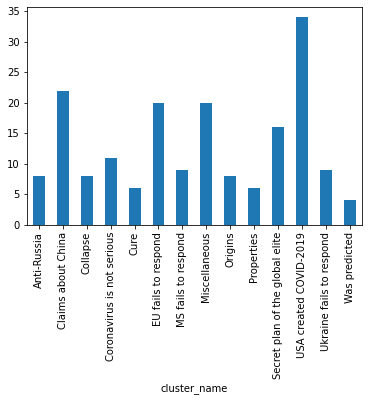

In [15]:
# Get the number of articles per original cluster
data_pack_copy.groupby(['cluster_name']).size().plot.bar()

In [16]:
# Column names for the new clusters created
new_clusters_created

['cluster_L/A',
 'cluster_L/B',
 'cluster_L/C',
 'cluster_L/D',
 'cluster_L/E',
 'cluster_L/F']

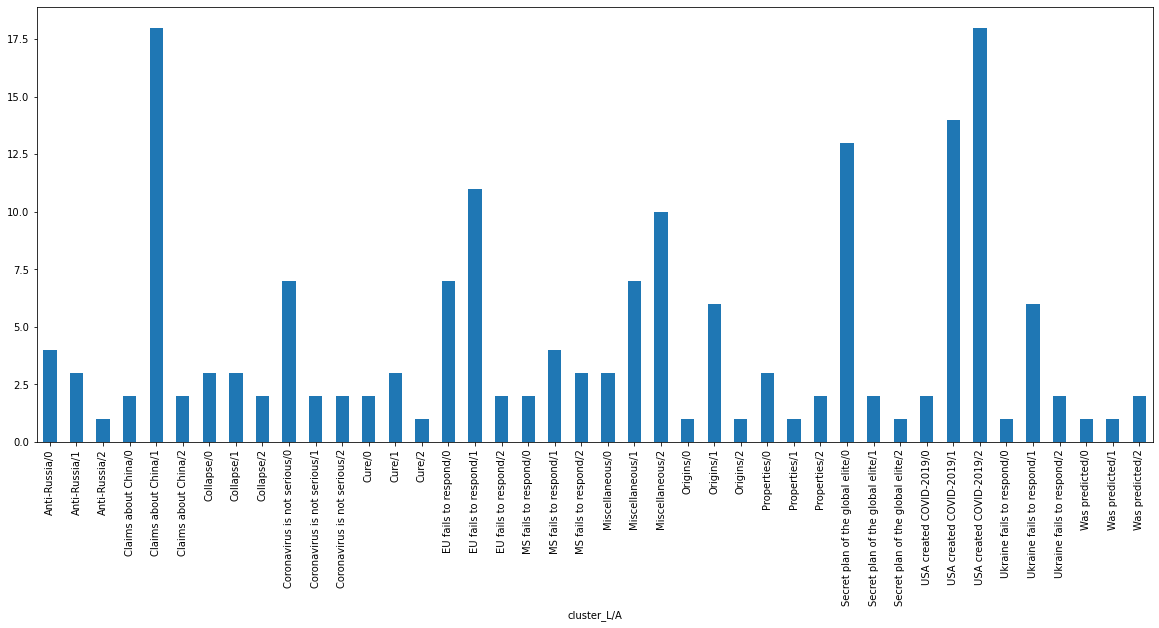

In [27]:
# Plot the number articles in each Cluster for level 1
plt.figure(figsize=(20,8))
data_pack_copy.groupby(['cluster_L/A']).size().plot.bar()

 Example: Documents within cluster cure/0 cure/1 cure/2 were extracted from the parent cluster cure

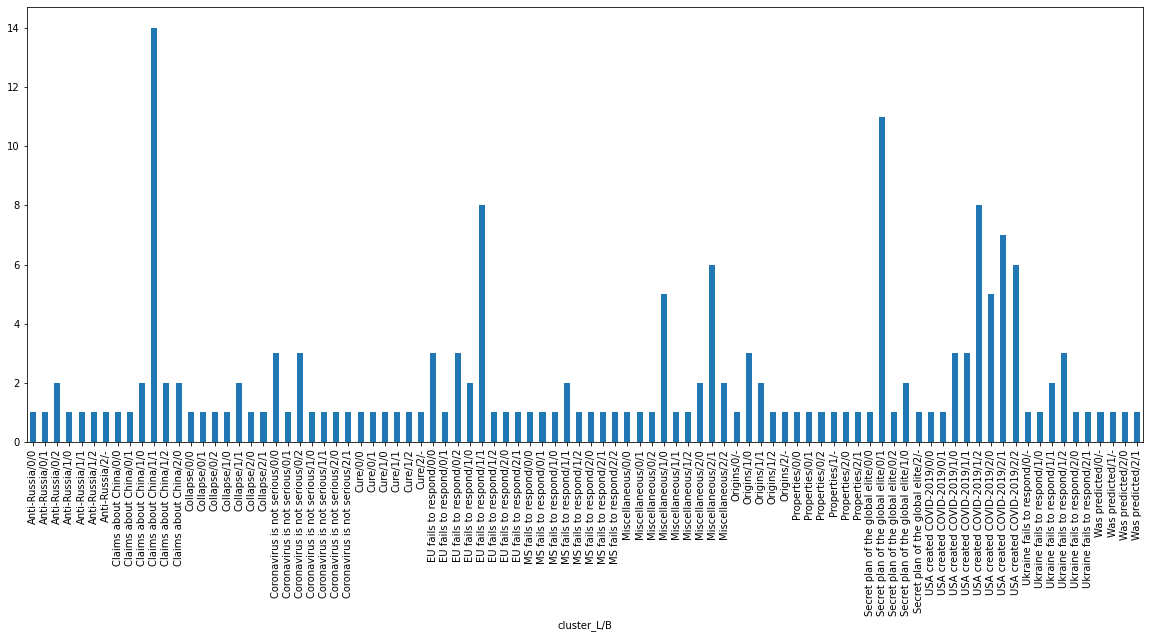

In [28]:
# Plot the number articles in each Cluster for level 2
plt.figure(figsize=(20,8))
data_pack_copy.groupby(['cluster_L/B']).size().plot.bar()

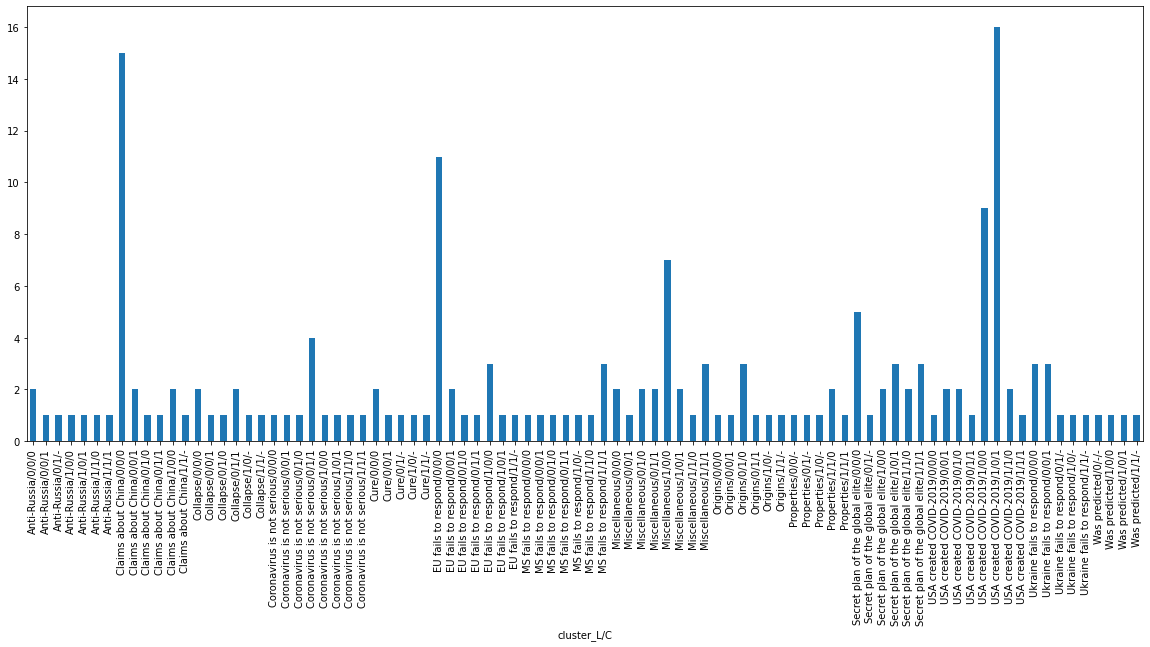

In [226]:
# Plot the number articles in each Cluster for level 3
plt.figure(figsize=(20,8))
data_pack_copy.groupby(['cluster_L/C']).size().plot.bar()

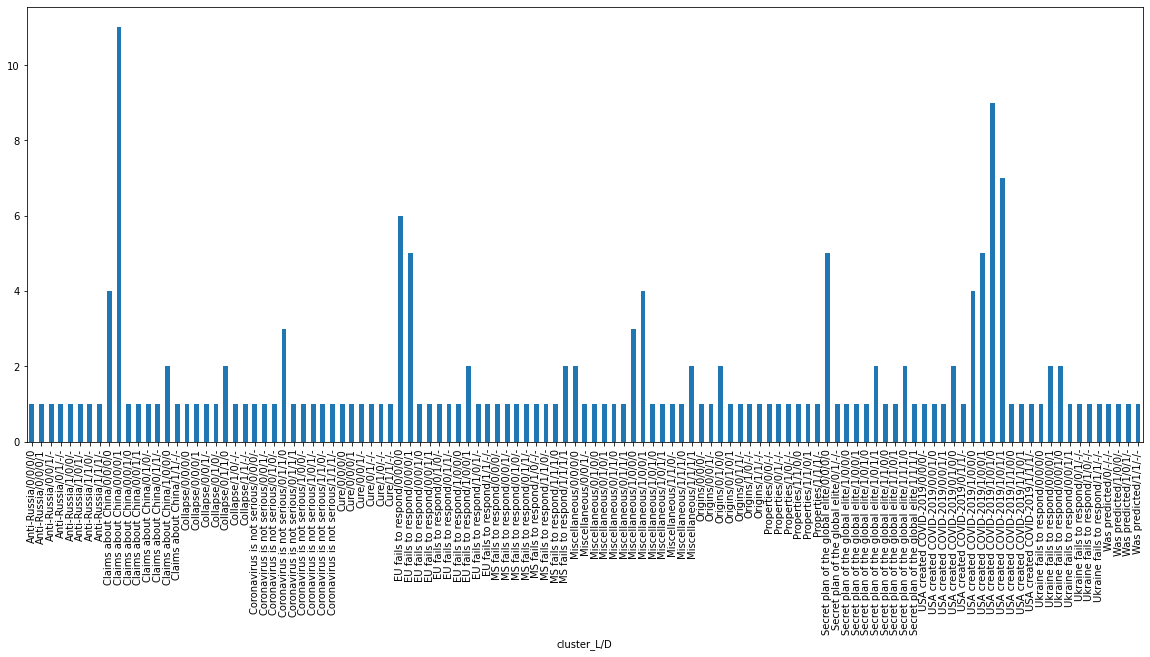

In [227]:
# Plot the number articles in each Cluster for level 4
plt.figure(figsize=(20,8))
data_pack_copy.groupby(['cluster_L/D']).size().plot.bar()

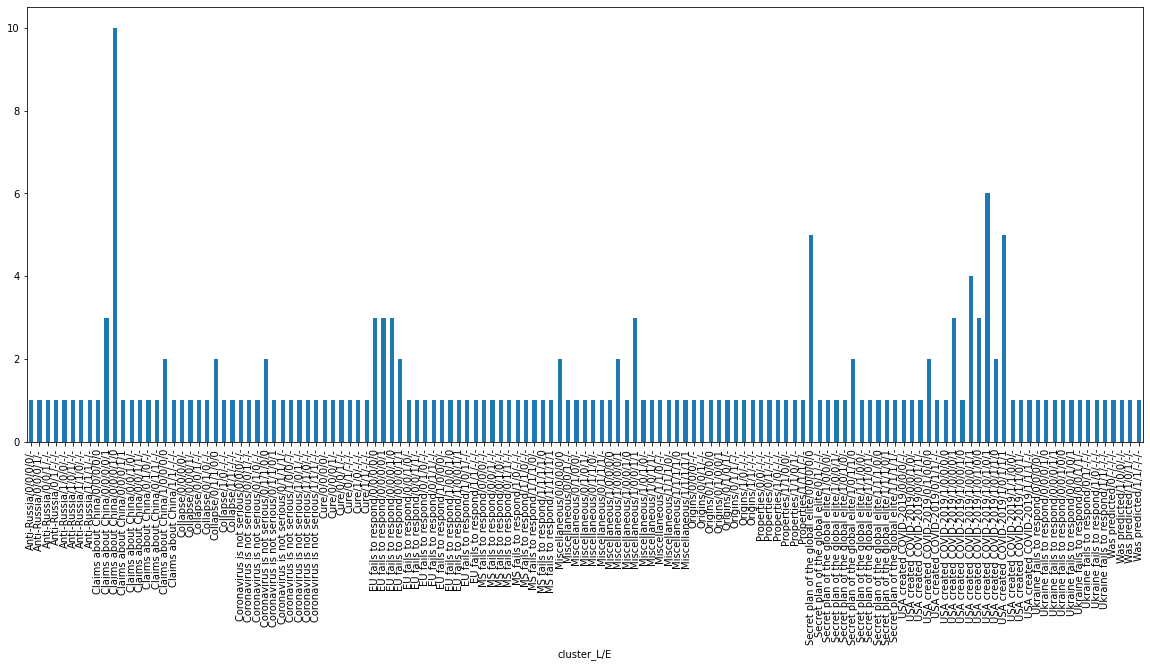

In [228]:
plt.figure(figsize=(20,8))
data_pack_copy.groupby(['cluster_L/E']).size().plot.bar()

In [145]:
dfg_new.tail()

,id,text,title,lang,date,cluster,cluster_name,content,XX,X/X,cluster_L/A,cluster_L/B
176,https://sputnik.by/video/20200122/1043758449/N...,Who represents China at the economic forum in ...,"""I do not believe this is accidental"": expert ...",eng,2020-01-22 10:00:00,13,USA created COVID-2019,"""I do not believe this is accidental"": expert ...",,,USA created COVID-2019/2,USA created COVID-2019/2/0
177,https://www.5-tv.ru/news/285271/epidemia-pando...,- Fifth channel\n- News\n- All news\nPandora's...,Pandora's epidemic: how the fear of coronaviru...,eng,None,12,Ukraine fails to respond,Pandora's epidemic: how the fear of coronaviru...,,,Ukraine fails to respond/1,Ukraine fails to respond/1/1
178,https://www.fondsk.ru/news/2020/03/31/v-italja...,"On March 30, Fabio Rampelli, deputy chairman o...",European Union flag lowered in Italian parliam...,eng,2020-03-31 00:00:00,6,EU fails to respond,European Union flag lowered in Italian parliam...,,,EU fails to respond/0,EU fails to respond/0/1
179,https://cz.sputniknews.com/ceskarepublika/2020...,"At the beginning of the interview, Luboš Vesel...",Stonjeková about eco-Greta: The media does not...,eng,None,7,Miscellaneous,Stonjeková about eco-Greta: The media does not...,,,Miscellaneous/2,Miscellaneous/2/2
180,https://de.sputniknews.com/kommentare/20200321...,The hiker was and is healthy. But the women ob...,The Virus Dictatorship: Conspiracy Against Fre...,eng,None,4,Coronavirus is not serious,The Virus Dictatorship: Conspiracy Against Fre...,,,Coronavirus is not serious/1,Coronavirus is not serious/1/0


In [78]:
dfg.loc[dfg['cluster_name']==base_clusters[0]]['cluster_L/A']

56     23
57     12
64     34
81      2
86      4
88     23
109    12
131    34
Name: cluster_L/A, dtype: object

In [24]:
# Lets see the clusters upto level B
data_pack_copy.groupby(['cluster_name','cluster_L/A','cluster_L/B',]).size()

cluster_name              cluster_L/A                 cluster_L/B                 
Anti-Russia               Anti-Russia/0               Anti-Russia/0/0                 1
                                                      Anti-Russia/0/1                 1
                                                      Anti-Russia/0/2                 2
                          Anti-Russia/1               Anti-Russia/1/0                 1
                                                      Anti-Russia/1/1                 1
                                                                                     ..
Ukraine fails to respond  Ukraine fails to respond/2  Ukraine fails to respond/2/1    1
Was predicted             Was predicted/0             Was predicted/0/-               1
                          Was predicted/1             Was predicted/1/-               1
                          Was predicted/2             Was predicted/2/0               1
                                     

In [25]:
# Lets see the clusters upto level C
data_pack_copy.groupby(['cluster_name','cluster_L/A','cluster_L/B','cluster_L/C']).size()

cluster_name              cluster_L/A                 cluster_L/B                   cluster_L/C                   
Anti-Russia               Anti-Russia/0               Anti-Russia/0/0               Anti-Russia/0/0/-                 1
                                                      Anti-Russia/0/1               Anti-Russia/0/1/-                 1
                                                      Anti-Russia/0/2               Anti-Russia/0/2/0                 1
                                                                                    Anti-Russia/0/2/1                 1
                          Anti-Russia/1               Anti-Russia/1/0               Anti-Russia/1/0/-                 1
                                                                                                                     ..
Ukraine fails to respond  Ukraine fails to respond/2  Ukraine fails to respond/2/1  Ukraine fails to respond/2/1/-    1
Was predicted             Was predicted/0    

Ignoring the predefined clusters let try some cluster algorithms

In [ ]:
# Task Completed

In [ ]:
# To cluster the documents into fine-grain clusters, we can use Hierarchical/Agglomerative cluster algorithm such as the Ward Clustering Algorithm
# At each stage of the Ward Algorithm, 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=14, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)